In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp

## Setup

### Load Data

Here I have used the following code in R to convert the .RData file to .csvs:

write.csv(friend, "friend.csv")

write.csv(inschool, "inschool.csv")

In [2]:
friends_raw = pd.read_csv('friend.csv').drop(columns='Unnamed: 0')
schools_raw = pd.read_csv('inschool.csv').drop(columns='Unnamed: 0')

## Exercise 1

### Testing

Since it is hard to understand what is happening with such large graphs I have replicated the small one we saw in the lecture to test out the methods.

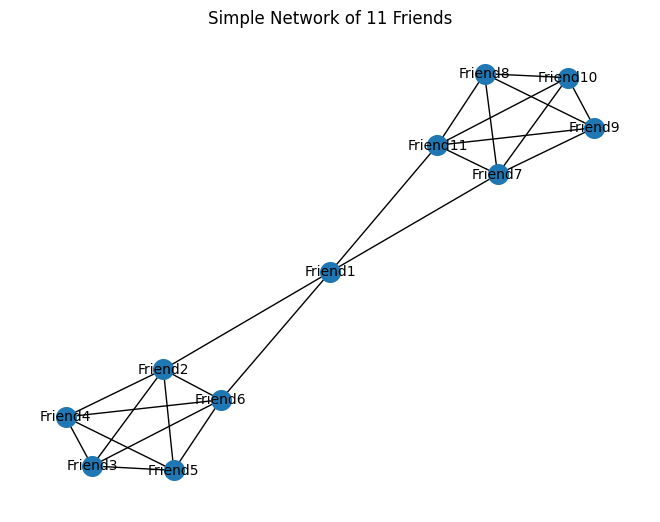

In [3]:
# Create an empty graph
G = nx.Graph()

# Add nodes
friends = ["Friend" + str(i) for i in range(1, 11)]
G.add_nodes_from(friends)

# Add edges between friends
edges = [("Friend1", "Friend2"), ("Friend1", "Friend6"), ("Friend1", "Friend7"), ("Friend1", "Friend11"),
         ("Friend2", "Friend3"), ("Friend2", "Friend4"), ("Friend2", "Friend5"), ("Friend2", "Friend6"),
         ("Friend6", "Friend5"), ("Friend6", "Friend4"), ("Friend6", "Friend3"), ("Friend3", "Friend4"),
         ("Friend7", "Friend8"), ("Friend7", "Friend9"), ("Friend7", "Friend10"), ("Friend7", "Friend11"),
         ("Friend11", "Friend10"), ("Friend11", "Friend9"), ("Friend11", "Friend8"), ("Friend8", "Friend9"),
         ("Friend9", "Friend10"), ("Friend4", "Friend5"), ("Friend5", "Friend3"), ("Friend10", "Friend8")]

G.add_edges_from(edges)

# Draw the network
nx.draw(G, with_labels=True, node_size=200, font_size=10)
plt.title("Simple Network of 11 Friends")
plt.show()


In [4]:
adjacency_matrix = nx.adjacency_matrix(G).astype(np.float64)
adjacency_matrix_sparse = sp.csr_matrix(adjacency_matrix) # much faster using sparse matrix, shoutout to Daniel

eigval1 = sp.linalg.eigsh(adjacency_matrix_sparse, k=1, which='LA', return_eigenvectors=False)
        
max(eigval1) # max here just to return a float isntead of array

4.404046996464427

In [5]:
beta = 0.1
n = adjacency_matrix.shape[0]
I = np.eye(n)  # Identity matrix
# Bonacich centrality
C = np.linalg.inv(I - beta * adjacency_matrix) @ (beta * adjacency_matrix @ np.ones((adjacency_matrix.shape[0], 1)))
            
bonacich_centrality = C.flatten()
bonacich_centrality

array([0.75159236, 0.87898089, 0.71974522, 0.71974522, 0.71974522,
       0.87898089, 0.87898089, 0.71974522, 0.71974522, 0.71974522,
       0.87898089])

In [6]:
node_names = np.array(G.nodes())
# Labels dictionary with bonacich centrality as labels
labels_dict = {}
for i, node in enumerate(node_names):
    labels_dict[node] = round(bonacich_centrality[i],3)

print(labels_dict)

{'Friend1': 0.752, 'Friend2': 0.879, 'Friend3': 0.72, 'Friend4': 0.72, 'Friend5': 0.72, 'Friend6': 0.879, 'Friend7': 0.879, 'Friend8': 0.72, 'Friend9': 0.72, 'Friend10': 0.72, 'Friend11': 0.879}


{0: '0.752', 1: '0.879', 2: '0.72', 3: '0.72', 4: '0.72', 5: '0.879', 6: '0.879', 7: '0.72', 8: '0.72', 9: '0.72', 10: '0.879'}


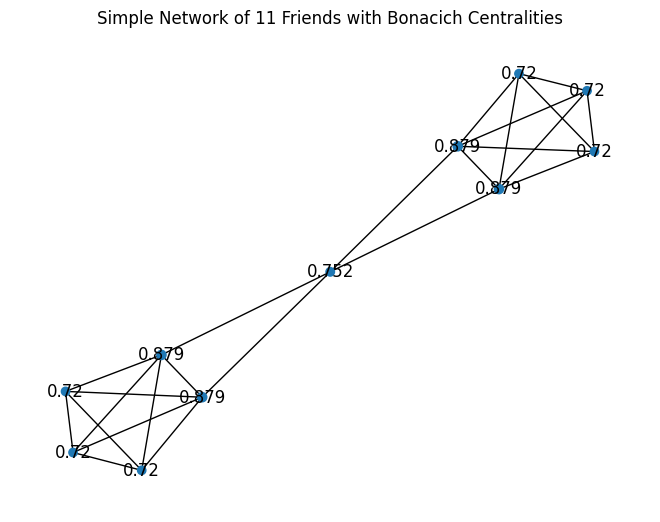

In [7]:
labels = {}
for i in range(len(bonacich_centrality)):
    labels[i] = str(round(bonacich_centrality[i],3))
print(labels)

nx.draw(G, with_labels=True, node_size=bonacich_centrality*50, labels=labels_dict)
plt.title("Simple Network of 11 Friends with Bonacich Centralities")
plt.show()

The method below to get the loops uses that each loop has to go through a neighbor before returning to the starting node. All paths from the starting node to a node that is a neighbor are therefore loops. nx.all_simple_paths also doesnt repeat nodes so only a node with at least two neighbors can have loops which makes sense to me.

In [8]:
list(nx.all_simple_paths(G, source='Friend1', target='Friend2'))

[['Friend1', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend4', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend4', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend3', 'Friend4', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend3', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend5', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend4', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend4', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend5', 'Friend4', 'Friend2']]

In [9]:
node_to_loops = {}
for source_node in G.nodes():
    paths = []
    for target in G.neighbors(source_node):
         # all paths to neighbors that do not go through the same node twice
        paths_to_neighbors = list(nx.all_simple_paths(G, source=source_node, target=target))
        # only those that are longer than 2 (the starting node is included so when len(l)=2 it is not a loop just an edge to a neighbor)
        paths += [l + [source_node] for l in paths_to_neighbors if len(l) > 2]
    node_to_loops[source_node] = paths
    print(f'Amount of loops starting from {source_node}:  {len(node_to_loops[source_node])}') # take length of the list as the amount of loops

print(node_to_loops['Friend2'])

Amount of loops starting from Friend1:  64
Amount of loops starting from Friend2:  92
Amount of loops starting from Friend3:  82
Amount of loops starting from Friend4:  82
Amount of loops starting from Friend5:  82
Amount of loops starting from Friend6:  92
Amount of loops starting from Friend7:  92
Amount of loops starting from Friend8:  82
Amount of loops starting from Friend9:  82
Amount of loops starting from Friend10:  82
Amount of loops starting from Friend11:  92
[['Friend2', 'Friend3', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend3', 'Friend4', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend3', 'Friend4', 'Friend5', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend3', 'Friend5', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend3', 'Friend5', 'Friend4', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend4', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend4', 'Friend3', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend4', 'Friend3', 'Friend5', 'Fr

Even in this small graph there are many possible loops.

In [10]:
key_players = []
max_intercentrality = 0

for i, node in enumerate(G.nodes()):
    intercentrality = round((bonacich_centrality[i])**2 / len(node_to_loops[source_node]), 5)
    if intercentrality > max_intercentrality:
        key_players = [node]
        max_intercentrality = intercentrality

    elif intercentrality == max_intercentrality:
        key_players.append(node)

    print(f'Node: {node} intercentrality: {intercentrality}')

key_players


Node: Friend1 intercentrality: 0.00614
Node: Friend2 intercentrality: 0.0084
Node: Friend3 intercentrality: 0.00563
Node: Friend4 intercentrality: 0.00563
Node: Friend5 intercentrality: 0.00563
Node: Friend6 intercentrality: 0.0084
Node: Friend7 intercentrality: 0.0084
Node: Friend8 intercentrality: 0.00563
Node: Friend9 intercentrality: 0.00563
Node: Friend10 intercentrality: 0.00563
Node: Friend11 intercentrality: 0.0084


['Friend2', 'Friend6', 'Friend7', 'Friend11']

As we saw in the lecture, the nodes connected to the center node are the ones with the highest bonacich centrality and also the key players (but that doesnt have to be the case always)

### Code

I thought it would be a good idea to use Object Oriented Programming, unfortunately it turned out making everything harder.

The steps are the following:
- **cleaning**: First merging on 'aid', then turning weird ids into missing values and dropping missing 'aid'

- **graphs**: For each school, initialising an empty graph, then adding nodes and edges. Finally just keep the largest connected subgraph. The way I have decided to structure the data is in a dictionary, with the school codes as keys, graphs as items.

- **largest eigenvalue**: Much faster due to using sparse matrix (shoutout to Daniel for the tip!)

- **Bonacich**: According to formula: $$b(g,β)=(I−βG)−1⋅(βG1)$$ Returns another dictionary with the bonacich centrality, which in hindsight could have been part of the main dictionary with the graphs

- **activity**: Adds the activity of each node for each school as an array to the graphs dictionary.

- **aggregate activity**: Sums the activities for each school, adds that value to the graphs dictionary and plots the distribution of normalized aggregate activity

- **median school**: Unfortunately computes the aggregate activities again because the way I saved them in the dictionary would have required another for loop to access them anyway. Then finds the median school.

- **key player**: Here I was not very sure how to interpret $m_{ii}$. I have seen it defined as: "sum of all loops starting from i and ending at i" (Ballester et al 2005) I imagined that even though our graph is undirected, if there is a loop from node 1 to node 2 to node 3 and back to node 1, there also is a loop from node 1 to node 3 to node 2 and back to node 1. Not sure if that is a duplicate. Also, I imagine a loop cannot pass through the same node twice, which means that nodes only connected with one player have no loops and in the formula $ci(g,a)=\frac{bi(g,a)^2}{mii(g,a)}$ we would be dividing by zero? In any case, for a dense graph this method takes forever. So long that I've never seen it finish running. This is the reason why I had to instantiate the class again with a resampled median school (only 20\% of the size of the median school).

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

class ex1:
    def __init__(self, friends_raw, schools_raw):

        self.data_raw = pd.merge(schools_raw, friends_raw, on='sqid')  # merge raw data

        # placehodlers
        self.data = pd.DataFrame()  # cleaned data
        self.school_graphs = {}  # school graphs
        self.eigenvalues = {}  # largest eigenvalues
        self.filtered_schools = {}  # filtered schools
        self.bonacich = {}  # bonacich centrality
        self.aggregate_activities = {}

    def clean(self):
        
        self.data = self.data_raw.replace([77777777, 88888888, 99999999], np.nan) #replace with missing values
        self.data = self.data.dropna(subset=['aid']) # remove missing values in aid column
        return self.data

    def generate_graphs(self):

        for school_code, school_df in self.data.groupby('sschlcde'):
            
            # empty graph at first
            G_school = nx.Graph()
            for _, row in school_df.iterrows():
                
                G_school.add_node(row['aid'])
                
                edges = [(row['aid'], friend_id) for friend_id in row[['mf1aid', 'mf2aid', 'mf3aid', 'mf4aid', 'mf5aid', 
                                                                      'ff1aid', 'ff2aid', 'ff3aid', 'ff4aid', 'ff5aid']].dropna()]
                
                G_school.add_edges_from(edges)
            
            # find the largest connected component for each school
            largest_component = max(nx.connected_components(G_school), key=len)
            largest_component_graph = G_school.subgraph(largest_component)
            
            # add to dictionary
            self.school_graphs[school_code] = largest_component_graph

        return self.school_graphs

    def _compute_largest_eigenvalue(self, graph):

        adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
        # Convert adjacency matrix to sparse matrix with data type 'float64'
        adjacency_matrix_sparse = sp.csr_matrix(adjacency_matrix, dtype=np.float64)
        # Compute eigenvalues
        eigenvalues, _ = eigs(adjacency_matrix_sparse, k=1, which='LR')  # k=1 for largest eigenvalue
        largest_eigenvalue = max(eigenvalues)  # Extract the largest eigenvalue

        return largest_eigenvalue

    def compute_largest_eigenvalues_and_filter(self, beta):
        
        for school_code, graph in self.school_graphs.items():

            largest_eigenvalue = self._compute_largest_eigenvalue(graph) #call hidden method for each graph
            #print(largest_eigenvalue)
            # Filter out
            if beta < (1 / largest_eigenvalue): 
                self.filtered_schools[school_code] = {
                    'graph': graph,
                    'largest_eigenvalue': largest_eigenvalue
                }
                self.eigenvalues[school_code] = largest_eigenvalue
        
        return self.filtered_schools
    
    def compute_bonacich_centrality(self, beta):
        # Compute Bonacich centrality for filtered schools
        for school_code, school_data in self.filtered_schools.items():
            graph = school_data['graph']
            adjacency_matrix = nx.adjacency_matrix(graph)
            
            n = adjacency_matrix.shape[0]
            I = np.eye(n)  # Identity matrix
            C = np.linalg.inv(I - beta * adjacency_matrix) @ (beta * adjacency_matrix @ np.ones((adjacency_matrix.shape[0], 1)))
            bonacich_centrality = C.flatten()
            self.bonacich[school_code] = bonacich_centrality
        return self.bonacich
    
    def compute_activity(self, alpha=0.01, beta=0.1):
        # Compute the interior solution for filtered schools
        for school_code, school_data in self.filtered_schools.items():
            graph = school_data['graph']
            adjacency_matrix = nx.adjacency_matrix(graph)
            
            n = adjacency_matrix.shape[0]
            I = np.eye(n)  # Identity matrix
            
            # Compute (I - beta * G)^-1
            inverse_matrix = np.linalg.inv(I - beta * adjacency_matrix)

            # Compute x* = alpha * (I - beta * G)^-1 * 1
            ones_vector = np.ones((n, 1))
            activity = alpha * np.dot(inverse_matrix, ones_vector).flatten()

            # Store the interior solution
            school_data['activity'] = activity

        return self.filtered_schools
    
    def aggregate_activity(self, plot):
        # Calculate aggregate activity per school normalized by school size
        aggregate_activities = []  # Store aggregate activities for all schools

        for school_code, school_data in self.filtered_schools.items():
            activity = school_data.get('activity', None)
            if activity is not None:
                aggregate_activity = np.sum(activity) / len(activity)  # Normalize by school size
                school_data['aggregate_activity'] = aggregate_activity
                aggregate_activities.append(aggregate_activity)  # Append to the list

        if plot:
            # Plot the distribution of aggregate activity
            plt.figure(figsize=(8, 6))
            plt.hist(aggregate_activities, bins=50, color='skyblue', edgecolor='black')
            plt.title('Distribution of Aggregate Activity per School (Normalized by School Size)')
            plt.xlabel('Aggregate Activity per School (Normalized)')
            plt.ylabel('Frequency')
            plt.show()

        
    def find_median_school(self):
        #Unfortunately need to calculate agg activity again
        # Calculate aggregate activity per school normalized by school size
        aggregate_activities = []

        for school_code, school_data in self.filtered_schools.items():
            activity = school_data.get('activity', None)
            if activity is not None:
                aggregate_activity = np.sum(activity) / len(activity)  # Normalize by school size
                school_data['aggregate_activity'] = aggregate_activity
                aggregate_activities.append((aggregate_activity, school_code))  # Append to the list

        # Sort the aggregate activities
        sorted_aggregate_activities = sorted(aggregate_activities)

        # Find the median
        median_index = (len(sorted_aggregate_activities) // 2) - 1 # minus one because of the python indexing
        median_activity = sorted_aggregate_activities[median_index][0]

        # Find the school with the median aggregate activity
        median_school = None
        for activity, school_code in sorted_aggregate_activities:
            if activity == median_activity:
                median_school = school_code
                break

        return median_school
    
    def key_player(self, graph):
        node_to_loops = {}
        for source_node in graph.nodes():
            paths = []
            for target in graph.neighbors(source_node):
                # all paths to neighbors that do not go through the same node twice
                paths_to_neighbors = list(nx.all_simple_paths(graph, source=source_node, target=target))
                # only those that are longer than 2 (the starting node is included so when len(l)=2 it is not a loop just an edge to a neighbor)
                paths += [l + [source_node] for l in paths_to_neighbors if len(l) > 2]
            node_to_loops[source_node] = paths

        key_players = []
        key_player_c = 0

        for i, node in enumerate(graph.nodes()):
            if len(node_to_loops[node]) == 0:
                continue  # Skip nodes with no loops
            # compute according to formula c_i = B_i^2 / m_ii
            intercentrality = round((self.bonacich[i])**2 / len(node_to_loops[node]), 4) # take length of the list as the amount of loops
            if intercentrality >= key_player_c:
                if intercentrality > key_player_c:
                    key_players = []  # Clear the list if a higher intercentrality is found
                key_players.append(node)
                key_player_c = intercentrality
            print(f'Node: {node} intercentrality: {intercentrality}')

        return key_players

In [12]:
ex_one = ex1(friends_raw, schools_raw)

data = ex_one.clean()

In [13]:
school_graphs = ex_one.generate_graphs()

In [14]:
filtered_schools = ex_one.compute_largest_eigenvalues_and_filter(beta=0.1)

In [15]:
bonacich_centralities = ex_one.compute_bonacich_centrality(beta=0.1)

In [16]:
school_graphs = ex_one.compute_activity(alpha=0.01, beta=0.1)

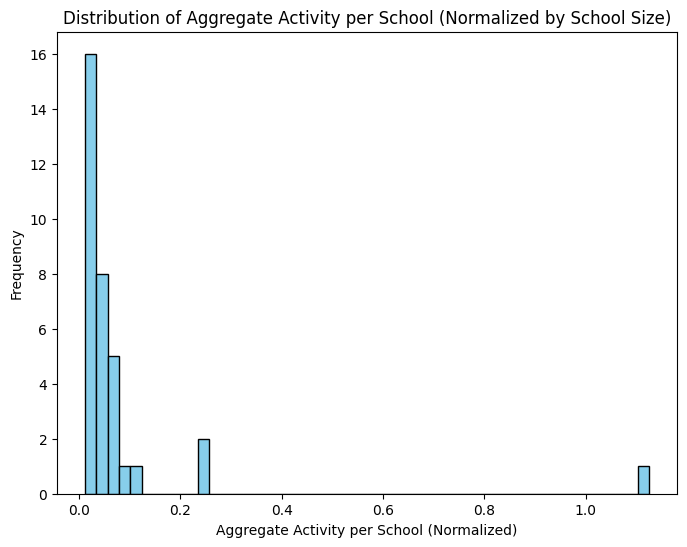

In [17]:
ex_one.aggregate_activity(plot=True)

In [18]:
ex_one.find_median_school()

168

168 is the median school, however I decide to take the next school because it is much smaller in size and makes for better plots and less runtime.

In [19]:
node_names = np.array(school_graphs[28]['graph'].nodes())

labels_dict = {}
for i, node in enumerate(node_names):
    labels_dict[node] = round(bonacich_centralities[28][i],3)

print(labels_dict)

{90575942.0: 2.863, 98575944.0: 5.089, 90575944.0: 3.725, 96575946.0: 4.265, 97575245.0: 4.072, 99575948.0: 5.352, 90575244.0: 3.067, 99575944.0: 2.399, 96575942.0: 2.028, 97575240.0: 4.584, 96575246.0: 1.062, 98575946.0: 2.331, 97575242.0: 16.603, 94575247.0: 2.443, 99575941.0: 1.962, 93575240.0: 6.964, 91575244.0: 8.811, 90575940.0: 5.989, 97575948.0: 10.841, 98575945.0: 13.489, 94575244.0: 7.821, 91575942.0: 10.384, 96575947.0: 10.205, 91575246.0: 4.781, 94575940.0: 3.83, 99575245.0: 1.066, 98575948.0: 4.751, 93575248.0: 6.369, 97575943.0: 1.211, 94575943.0: 1.693, 95575945.0: 2.507, 96575949.0: 2.656, 90575246.0: 1.811, 92575244.0: 1.429, 95575248.0: 1.252, 90575948.0: 8.548, 92575243.0: 3.517, 96575948.0: 3.602, 90575949.0: 3.09, 96575945.0: 4.88, 90575946.0: 8.54, 92575946.0: 3.018, 91575948.0: 3.943, 99575949.0: 3.836, 91575249.0: 8.022, 97575941.0: 4.373, 90575947.0: 1.387, 92575247.0: 6.28, 94575243.0: 5.901, 96575941.0: 4.472, 95575243.0: 8.46, 92575941.0: 6.308, 95575949.0: 

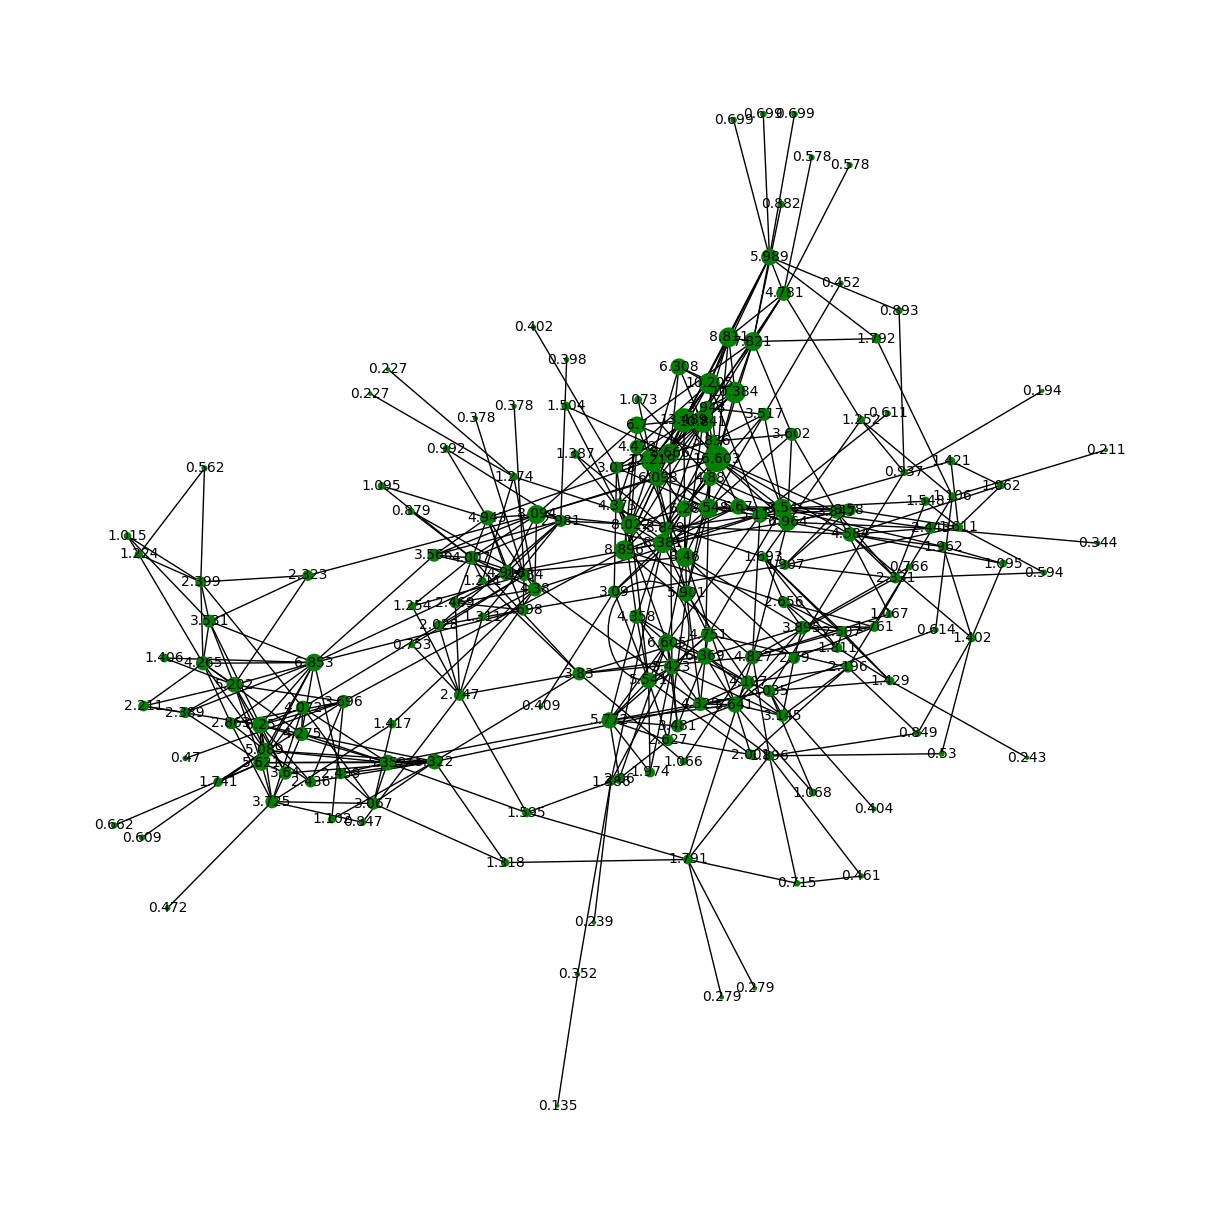

In [20]:
plt.figure(figsize=(12, 12))
nx.draw(school_graphs[28]['graph'], with_labels=True, node_size=bonacich_centralities[28]*20, labels=labels_dict, node_color='green', font_size=10)
plt.show()

In [21]:
schools_raw_28 = schools_raw[schools_raw['sschlcde'] == 28].sample(frac=0.2, random_state=8) # just a fraction because computationally costly

In [22]:
ex_one_f = ex1(friends_raw, schools_raw_28) # new class with just one the fraction of one school

# same steps as before
data = ex_one_f.clean()
school_graphs = ex_one_f.generate_graphs()
filtered_schools = ex_one_f.compute_largest_eigenvalues_and_filter(beta=0.1)
bonacich_centralities = ex_one_f.compute_bonacich_centrality(beta=0.1)
school_graphs = ex_one_f.compute_activity(alpha=0.01, beta=0.1)

In [23]:
graph = school_graphs[28]['graph']
node_to_loops = {}

for source_node in graph.nodes():
    paths = []
    for target in graph.neighbors(source_node):
        # all paths to neighbors that do not go through the same node twice
        paths_to_neighbors = list(nx.all_simple_paths(graph, source=source_node, target=target))
        # only those that are longer than 2 (the starting node is included so when len(l)=2 it is not a loop just an edge to a neighbor)
        paths += [l + [source_node] for l in paths_to_neighbors if len(l) > 2]
        node_to_loops[source_node] = paths

key_players = []
key_player_c = 0

for i, node in enumerate(graph.nodes()):
    if len(node_to_loops[node]) == 0:
        continue  # Skip nodes with no simple paths

    intercentrality = round((bonacich_centralities[28][i])**2 / len(node_to_loops[node]), 4)
    if intercentrality >= key_player_c:
        if intercentrality > key_player_c:
            key_players = []  # Clear the list if a higher intercentrality is found
        key_players.append(node)
        key_player_c = intercentrality
    print(f'Node: {node} intercentrality: {intercentrality}')

key_players

Node: 97575941.0 intercentrality: 0.0046
Node: 93575944.0 intercentrality: 0.0057
Node: 90575240.0 intercentrality: 0.0515
Node: 90575242.0 intercentrality: 0.0105
Node: 90575243.0 intercentrality: 0.0051
Node: 93575948.0 intercentrality: 0.0051
Node: 92575241.0 intercentrality: 0.1848
Node: 92575246.0 intercentrality: 0.0133
Node: 98575248.0 intercentrality: 0.0123
Node: 96575249.0 intercentrality: 0.0029
Node: 94575942.0 intercentrality: 0.0033
Node: 95575240.0 intercentrality: 0.005
Node: 91575242.0 intercentrality: 0.0057
Node: 95575243.0 intercentrality: 0.0019
Node: 97575244.0 intercentrality: 0.0053
Node: 95575245.0 intercentrality: 0.0051
Node: 91575249.0 intercentrality: 0.003
Node: 95575249.0 intercentrality: 0.0032
Node: 93575248.0 intercentrality: 0.0515


[92575241.0]

In [24]:
# dictionary to set bonacich as labels
node_names = np.array(school_graphs[28]['graph'].nodes())
labels_dict = {}
for i, node in enumerate(node_names):
    labels_dict[node] = round(bonacich_centralities[28][i],3)

#print(labels_dict)

In [25]:
# set key player to different color
color_mapping = []

for node in graph.nodes():
    if node == key_players[0]:
        color_mapping.append('red')
    else:
        color_mapping.append('green')

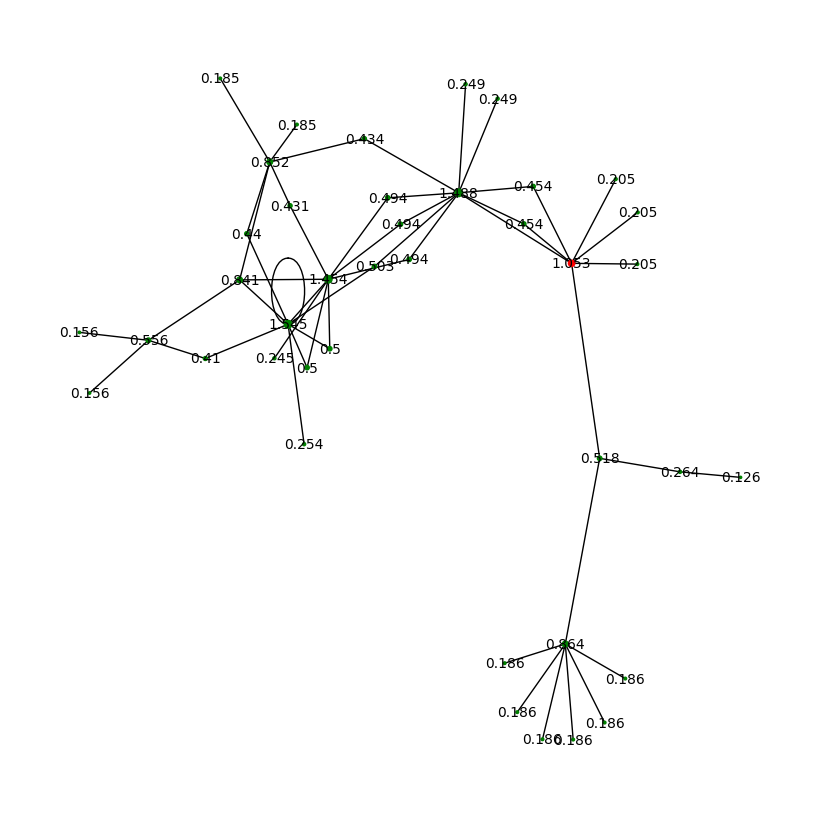

In [26]:
plt.figure(figsize=(8, 8))
nx.draw(school_graphs[28]['graph'], with_labels=True, node_size=bonacich_centralities[28]*20, labels=labels_dict, node_color=color_mapping, font_size=10)
plt.show()

In [27]:
np.sum(school_graphs[28]['activity'])

0.5858226225336388

In [28]:
schools_raw_28_no_key_player = schools_raw_28[schools_raw_28['aid'] != key_players[0]]

In [29]:
ex_one_f2 = ex1(friends_raw, schools_raw_28_no_key_player)

data = ex_one_f2.clean()
school_graphs = ex_one_f2.generate_graphs()
school_graphs
filtered_schools = ex_one_f2.compute_largest_eigenvalues_and_filter(beta=0.1)
bonacich_centralities = ex_one_f2.compute_bonacich_centrality(beta=0.1)
school_graphs = ex_one_f2.compute_activity(alpha=0.01, beta=0.1)
np.sum(school_graphs[28]['activity'])

0.4057491815884997

With the removal of the key player the aggregate activity declines considerably because the node was the only connection between two large parts of the graph. However, it is by far not the player with the highest bonacich centrality.

## Exercise 2

In [30]:
# # # # ! pip install pyreadr
#!pip install igraph
# # ! pip install swifter
# ! pip install rpds
# i worked in tensorflow env

In [31]:
import pyreadr
import pandas as pd
import numpy as np
import igraph as ig
from linearmodels.iv import IV2SLS
import scipy.sparse as sp

In [32]:
# Load data and create df
addhealth = pyreadr.read_r("AddHealth.RData") 
friend = addhealth['friend']
inschool = addhealth['inschool']
df = inschool.merge(friend, on='sqid', how='left')

In [33]:
print(f'School data shape:', inschool.shape),
print(f'Friend data shape:', friend.shape)
print(f'Merged data shape:', df.shape)

School data shape: (90118, 45)
Friend data shape: (90118, 11)
Merged data shape: (121624, 55)


Cleaning process:

- Melt (transform to long format) the data to a node - to node format.
- Remove missing data, trash data and duplicates.
- Create a variable 'activity' this is an indication of how active the students are (for the second exercise).

In [34]:
# Transform into long format
df_long = df.melt(id_vars=['sqid', 'aid', 'sschlcde', 's1', 's2', 's12', 's18', 's44a1', 's44a2',
       's44a3', 's44a4', 's44a5', 's44a6', 's44a7', 's44a8', 's44a9', 's44a10',
       's44a11', 's44a12', 's44a13', 's44a14', 's44a15', 's44a16', 's44a17',
       's44a18', 's44a19', 's44a20', 's44a21', 's44a22', 's44a23', 's44a24',
       's44a25', 's44a26', 's44a27', 's44a28', 's44a29', 's44a30', 's44a31',
       's44a32', 's44a33', 's6a', 's6b', 's6c', 's6d', 's6e'], value_name = 'to_node_id')

In [35]:
df_long.columns

Index(['sqid', 'aid', 'sschlcde', 's1', 's2', 's12', 's18', 's44a1', 's44a2',
       's44a3', 's44a4', 's44a5', 's44a6', 's44a7', 's44a8', 's44a9', 's44a10',
       's44a11', 's44a12', 's44a13', 's44a14', 's44a15', 's44a16', 's44a17',
       's44a18', 's44a19', 's44a20', 's44a21', 's44a22', 's44a23', 's44a24',
       's44a25', 's44a26', 's44a27', 's44a28', 's44a29', 's44a30', 's44a31',
       's44a32', 's44a33', 's6a', 's6b', 's6c', 's6d', 's6e', 'variable',
       'to_node_id'],
      dtype='object')

In [36]:
df_long.shape

(1216240, 47)

In [37]:
df_long.isna().sum()

sqid               0
aid                0
sschlcde           0
s1              9080
s2              8570
s12            78480
s18            78080
s44a1              0
s44a2              0
s44a3              0
s44a4              0
s44a5              0
s44a6              0
s44a7              0
s44a8              0
s44a9              0
s44a10             0
s44a11             0
s44a12             0
s44a13             0
s44a14             0
s44a15             0
s44a16             0
s44a17             0
s44a18             0
s44a19             0
s44a20             0
s44a21             0
s44a22             0
s44a23             0
s44a24             0
s44a25             0
s44a26             0
s44a27             0
s44a28             0
s44a29             0
s44a30             0
s44a31             0
s44a32             0
s44a33             0
s6a                0
s6b                0
s6c                0
s6d                0
s6e                0
variable           0
to_node_id    637646
dtype: int64

In [38]:
# Drop NAs
df_long = df_long.dropna(subset=df_long.columns)

In [39]:
# Convert to string
df_long[['to_node_id', 'aid']] = df_long[['to_node_id', 'aid']].astype(str)

In [40]:
# Remove trash nodes
to_remove = ['', 99999999, 88888888, 77777777]
df_long = df_long[(~df_long['aid'].isin(to_remove)) & (~df_long['to_node_id'].isin(to_remove))]

In [41]:
# Remove rows whose to_node_id is not in aid column, as far as these are friends from outside school and we just don't know their 'features'
df_long = df_long[df_long['to_node_id'].isin(df_long['aid'].tolist())]

Create graph for each school:

In [42]:
import igraph as ig

In [43]:
class ex2:
    def __init__(self, data):
        
        self.data = data.melt(id_vars=['sqid', 'aid', 'sschlcde', 's1', 's2', 's12', 's18', 's44a1', 's44a2',
       's44a3', 's44a4', 's44a5', 's44a6', 's44a7', 's44a8', 's44a9', 's44a10',
       's44a11', 's44a12', 's44a13', 's44a14', 's44a15', 's44a16', 's44a17',
       's44a18', 's44a19', 's44a20', 's44a21', 's44a22', 's44a23', 's44a24',
       's44a25', 's44a26', 's44a27', 's44a28', 's44a29', 's44a30', 's44a31',
       's44a32', 's44a33', 's6a', 's6b', 's6c', 's6d', 's6e'], value_name = 'to_node_id')
        
        # Remove rows whose to_node_id is not in aid column, as far as these are friends from outside school and we just don't know their 'features'
        self.data = self.data[self.data['to_node_id'].isin(self.data['aid'].tolist())]
        
        # Create activity variable, summing all activities
        self.data['activity'] = self.data[['s44a1', 's44a2',
            's44a3', 's44a4', 's44a5', 's44a6', 's44a7', 's44a8', 's44a9', 's44a10',
            's44a11', 's44a12', 's44a13', 's44a14', 's44a15', 's44a16', 's44a17',
            's44a18', 's44a19', 's44a20', 's44a21', 's44a22', 's44a23', 's44a24',
            's44a25', 's44a26', 's44a27', 's44a28', 's44a29', 's44a30', 's44a31',
            's44a32', 's44a33']].sum(axis=1)
        
        self.data.drop_duplicates(subset=['aid','to_node_id'], inplace=True)

        self.graph = ig.Graph()# empty graph at first

    def generate_one_graph(self):
        
        # Add edges to the graph object
        self.graph = ig.Graph.TupleList(self.data[["aid", "to_node_id"]].itertuples(index=False), directed=False)

        # Add node attributes
        self.graph.vs['activity'] = pd.Series(self.graph.vs()['name']).to_frame().merge(self.data, how='left', left_on=0, right_on='aid')['activity']

        return self.graph
    
    def correct_activity(self):
        for node in self.graph.vs:
            if node['activity'] <= 3:
                node['activity'] = node['activity']
            else:
                node['activity'] = 4.0

In [92]:
median_school = schools_raw[schools_raw['sschlcde'] == 168].dropna(subset=['s1', 's2', 's12', 's18','s6a', 's6b', 's6c', 's6d', 's6e'])
# friends = friends_raw.dropna(thresh=friends_raw.shape[1] - 8)

ex_one_temp = ex1(friends_raw, median_school)

data = ex_one_temp.clean()

ex_two = ex2(data=data)

In [93]:
median_school = ex_two.generate_one_graph()
ex_two.correct_activity()

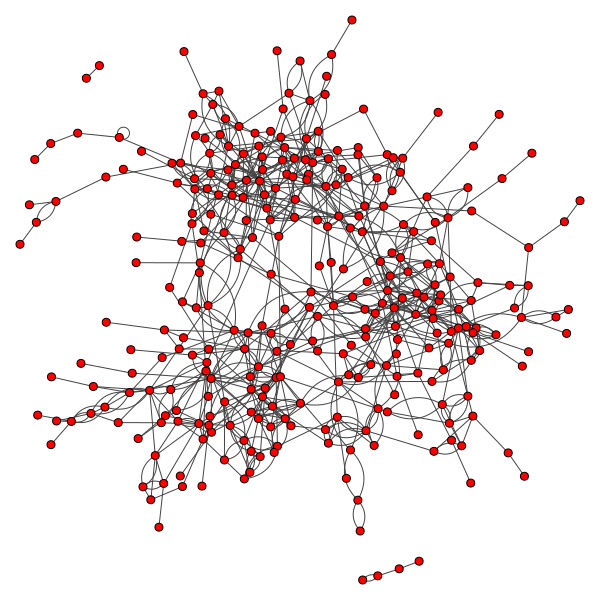

In [94]:
ig.plot(median_school, vertex_size=8)

In [95]:
# Check the number of vertices and edges
num_vertices = median_school.vcount()
num_edges = median_school.ecount()

print("Number of vertices:", num_vertices)
print("Number of edges:", num_edges)

Number of vertices: 309
Number of edges: 854


In [96]:
# import random
# # Select a random index from the range of available indices
# random_index = random.randint(0, len(graphs) - 1)

# # Get the graph corresponding to the random index
# median_school = graphs.iloc[random_index][0]

In [97]:
# Function to create y variable - activity index
def activity_index(node_activities):
    return [node if node <= 3 else 4 for node in node_activities]

median_school.vs['activity'] = activity_index(median_school.vs['activity'])

In [98]:
# Iterate over all vertices and print their activity attribute
for node in median_school.vs:
    print(f"Node {node.index}: Activity = {node['activity']}")

Node 0: Activity = 0.0
Node 1: Activity = 0.0
Node 2: Activity = 4
Node 3: Activity = 4
Node 4: Activity = 4
Node 5: Activity = 4
Node 6: Activity = 4
Node 7: Activity = 4
Node 8: Activity = 4
Node 9: Activity = 4
Node 10: Activity = 4
Node 11: Activity = 0.0
Node 12: Activity = 0.0
Node 13: Activity = 0.0
Node 14: Activity = 4
Node 15: Activity = 1.0
Node 16: Activity = 1.0
Node 17: Activity = 1.0
Node 18: Activity = 1.0
Node 19: Activity = 1.0
Node 20: Activity = 1.0
Node 21: Activity = 1.0
Node 22: Activity = 1.0
Node 23: Activity = 1.0
Node 24: Activity = 1.0
Node 25: Activity = 2.0
Node 26: Activity = 2.0
Node 27: Activity = 2.0
Node 28: Activity = 2.0
Node 29: Activity = 2.0
Node 30: Activity = 2.0
Node 31: Activity = 2.0
Node 32: Activity = 0.0
Node 33: Activity = 4
Node 34: Activity = 4
Node 35: Activity = 4
Node 36: Activity = 3.0
Node 37: Activity = 3.0
Node 38: Activity = 3.0
Node 39: Activity = 3.0
Node 40: Activity = 0.0
Node 41: Activity = 0.0
Node 42: Activity = 0.0
Node

(b) Following the results we saw in class, argue whether your network allows (or not) for point
identification of $θ = (α, β, γ)$.

Remember, that: 

$$y = αι + βGy + γX + ε,  E(ε|x) = 0$$

if $ηβ + γ \neq 0$ and $I, G, G^2$  are linearly independent, θ is point-identified

Also note, that contextual effects are captured by γ, in our case γ = 0.

Let's start with analyzing independence.


Check if $I, G, G^2$ are linearly independent

In [99]:
# Get adjacency matrix from median school
G = np.array(median_school.get_adjacency().data)

In [100]:
# Calculate I and G^2
I = np.identity(G.shape[0])
G2 = np.linalg.matrix_power(G, 2)

In [101]:
# Stack the matrices 
stacked_matrix = np.hstack((I, G, G2))

# Calculate the total number of rows in the stacked matrix
total_rows = stacked_matrix.shape[0]

# Check the rank of the stacked matrix
rank = np.linalg.matrix_rank(stacked_matrix)

# Print the total number of columns
print("Total number of rows in the stacked matrix:", total_rows)

# Print the rank
print("Rank of the stacked matrix:", rank)

# Check if the rank equals the total number of columns (linear independence check)
if rank == total_rows:
    print("The matrices are linearly independent.")
else:
    print("The matrices are linearly dependent.")

Total number of rows in the stacked matrix: 309
Rank of the stacked matrix: 309
The matrices are linearly independent.


(c) What is your vector of instruments? Is the model over-identified?


$G^2X$ could be used as an instrument for Gy, so we have to check the shape of the vector of instruments.

In [102]:
# Define y
y = np.array(median_school.vs['activity'])

In [103]:
# Perform Gy calculation 
Gy = np.dot(G, y)

In [104]:
len(median_school.vs['name'])

309

In [105]:
schools_raw.shape

(90118, 45)

In [106]:
# Define X

X = schools_raw[['s1', 's2', 's12', 's18', 's6a', 's6b', 's6c', 's6d', 's6e', 'aid']]
print(X.shape)

X = pd.merge(pd.DataFrame({'aid': median_school.vs['name']}), X, on='aid', how='left').drop(columns=['aid'])
print(X.shape)


(90118, 10)
(309, 9)


In [107]:
X = X.dropna()

In [108]:
X.shape

(309, 9)

In [109]:
G2.shape

(309, 309)

In [110]:
# Define IV
G2x = np.dot(G2, X)

In [111]:
# Check the shape of the resulting array
print("Shape of instruments vector:", G2x.shape)

Shape of instruments vector: (309, 9)


We are instrumenting $βGy$ only, which is one parameter to estimate and we have 9 instruments and this is over identified.

OR: as far as we want to estimate three parameters: $α, β, γ$, the number of instruments is more than that, so model is over-identified and there is vector of structural parameters can not be recovered uniquely from the reduced-form parameters.

(d) Compute the 2SLS estimator (i.e. the optimal GMM) for this model and provide a table with
your estimates of αˆ βˆ and γˆ with their standard errors. Is the estimated value of β greater
or smaller than the value of 0.1 that we assumed in the previous question?

In [112]:
# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X.shape[0]), X))

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y, exog=X_with_const, endog=Gy, instruments=G2x).fit()

# Print model summary
print(model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.0734
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0423
No. Observations:                 309   F-statistic:                    29.657
Date:                Thu, May 02 2024   P-value (F-stat)                0.0010
Time:                        00:36:39   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         3.2674     1.3975     2.3380     0.0194      0.5284      6.0064
exog.1        -0.1040     0.1060    -0.9812     0.32

We see, that our peer effect is insignificant in case of one school. But actually all exogenous features are also insignificant.

(e) Construct a block-diagonal matrix G that includes all the schools and repeat the previous
question. What is the estimate for the global endogenous effect across all schools?

In [ ]:
# Sample 30 schools (for the computational speed sake)
np.random.seed(42)
graphs_sample = graphs.sample(30).index
graph_list = graphs[0][graphs_sample]

In [ ]:
# Build block diagonal matrices
block_list_G = []
block_list_G2 = []

for graph in graph_list:
    G = np.array(graph.get_adjacency().data)
    block_list_G.append(G)
    G2 = np.linalg.matrix_power(G, 2)
    block_list_G2.append(G2)

block_G = sp.block_diag(block_list_G, format='csr')
block_G2 = sp.block_diag(block_list_G2, format='csr')

In [ ]:
# Function to calculate all activities
def list_activity(graphs):
    activity_list = []
    for graph in graphs:
        activity_list.extend(graph.vs['activity'])
    return np.nan_to_num(np.array(activity_list), nan=0)

y_all = list_activity(graph_list)

In [ ]:
# Calculate Gy
Gy = np.dot(block_G.toarray(), y_all)

In [ ]:
# Define X
features = inschool[['s1', 's2', 's12', 's18', 's6a', 's6b', 's6c', 's6d', 's6e', 'aid']]
X = pd.concat([pd.merge(pd.DataFrame({'aid': graph.vs['name']}), features, on='aid', how='left').drop(columns=['aid']) for graph in graph_list], axis=0)

In [ ]:
# Calculate G2x
G2x = np.dot(block_G2.toarray(), X)

In [ ]:
# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X.shape[0]), X))

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y_all, exog=X_with_const, endog=Gy, instruments=G2x).fit()

# Print model summary
print(model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.0217
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0209
No. Observations:               13075   F-statistic:                    83.205
Date:                Tue, Apr 30 2024   P-value (F-stat)                0.0000
Time:                        20:46:08   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         3.4982     0.2185     16.011     0.0000      3.0699      3.9264
exog.1        -0.0489     0.0127    -3.8559     0.00

We see very small but positive peer effect, which is actually significant=).

f) Finally, imagine that $E[ε | x] = α_s$ where $α_s$ differs for each school s. This means that there are school-specific unobservables which introduces an additional identification problem. We saw in class that we can take local differences to deal with this:
$$(I − G)y = β(I − G)Gy + (I − G)Xγ + v$$
Present a table with the estimates and standard error in this case. How do they differ from the previous ones?

In [ ]:
def get_X_stacked_fe(graph_list):
    features = inschool[['s1', 's2', 's12', 's18', 's6a', 's6b', 's6c', 's6d', 's6e', 'aid']]
    X_fe = pd.concat([pd.merge(pd.DataFrame({'aid': graph.vs['name']}), features, on='aid', how='left').drop(columns=['aid']).assign(alpha=idx) for idx, graph in enumerate(graph_list)], axis=0)
    return X_fe

In [ ]:
X_fe = get_X_stacked_fe(graph_list)

# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X_fe.shape[0]), X_fe))

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y_all, exog=X_with_const, endog=Gy, instruments=G2x).fit()

# Print model summary
print(model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.0216
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0208
No. Observations:               13075   F-statistic:                    89.086
Date:                Tue, Apr 30 2024   P-value (F-stat)                0.0000
Time:                        20:46:09   Distribution:                 chi2(11)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         3.5407     0.2141     16.534     0.0000      3.1210      3.9604
exog.1        -0.0460     0.0125    -3.6876     0.00

We also see very small but positive peer effect, which is actually significant=). In case of model with school fixed effect peer effect is slightly lower.